In [159]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import gaussian
import ActiveShapeModel 
import scipy
import cv2
from scipy import ndimage
import Image_preperation as prep

def calc_internal(p1,p2):
    if (np.array_equal(p1,p2)):
        return 100
    return np.sum( (p2 - p1)**2 )

def calc_internal_mean(p1,p2, mean):
    
    dist = scipy.spatial.distance.euclidean(p1,p2)
    diff = (mean - dist)**2
    return  diff

def calc_mean(points):
    
    size = len(points)
    p1 = points[-1]
    p2 = points[0]
    mean_sum = scipy.spatial.distance.euclidean(p1,p2)
    
    for i in range(size-1):
        p1 = points[i]
        p2 = points[i+1]
        mean_sum += scipy.spatial.distance.euclidean(p1,p2)
        
    return mean_sum / size

def calc_external_img(img):
    
    img = rgb2gray(img)
    
    sobelx64f = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
    abs_sobel64f = np.absolute(sobelx64f)
    sobelx = np.uint8(abs_sobel64f)
    
    sobely64f = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
    abs_sobel64f = np.absolute(sobely64f)
    sobely = np.uint8(abs_sobel64f)

    return -(sobelx + sobely)

def calc_external_img2(img): 

    img = np.array(img, dtype=np.uint16)
    kx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    Gx = cv2.filter2D(img,-1,kx)
    
    ky = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    Gy = cv2.filter2D(img,-1,ky)
    
    G = np.sqrt(Gx**2 + Gy**2)
    
    return -G
    
def calc_external(p, external_img):
    
    p = p.astype(int)
    
    return external_img[p[0],p[1]]
    
def calc_energy(p1, p2, external_img, alpha):
     
    internal = calc_internal(p1,p2)
    external = calc_external(p1, external_img)
    
    return internal + alpha * external


def calc_internal2(p1,p2,p3, alpha, beta):

    distance = alpha * (p3 - p2)**2
    curvature = beta * (p3 - 2*p2 + p1)**2 
    return np.sum( distance + curvature)


def calc_energy2(p1, p2, p3, external_img, alpha, beta, gamma):
     
    internal = calc_internal2(p1,p2, p3,alpha, beta)
    external = calc_external(p3, external_img)
    
    return internal + gamma * external

def calc_energy3(p1, p2, mean, external_img, alpha):
     
    internal = calc_internal_mean(p1,p2, mean)
    external = calc_external(p2, external_img)
    
    return alpha * internal + external



def get_point_state(point, number, pixel_width):
    
    n=0
    for i in range(-pixel_width , pixel_width+1):
        for j in range(-pixel_width , pixel_width+1):          
            if n == number:
                return np.array([point[0]+i , point[1]+j])
            n +=1
    return

def unpack(number, back_pointers, points, pixel_width):
    
    size = len(points)
    new_points = np.empty((size,2))
    
    new_points[-1] = get_point_state(points[-1],number, pixel_width)
    pointer = back_pointers[-1,number]
    
    for i in range(size-2, -1, -1):
        
        new_points[i] = get_point_state(points[i],pointer, pixel_width)
        pointer = back_pointers[i,pointer]
        
    return new_points

#https://courses.engr.illinois.edu/cs447/fa2017/Slides/Lecture07.pdf
def viterbi(points, img, pixel_width, alpha):
    size = len(points)
    num_states = (2*pixel_width +1)**2
    
    center = int((num_states-1)/2)
    
    trellis = np.empty((size, num_states), dtype=np.float16)
    back_pointers = np.empty((size, num_states), dtype=int)
    external_img = calc_external_img2(img)
    
    #init
    trellis[0,:] = np.zeros((num_states))
    back_pointers[0,:] = np.full((num_states),center)
    
    mean = calc_mean(points)
    
    #recursion
    for i in range(1, size):
        for t in range(num_states):
            trellis[i,t] = np.inf
            for d in range(num_states):
                p1 = get_point_state(points[i-1], d, pixel_width)
                p2 = get_point_state(points[i],t, pixel_width)
                #energy_trans = calc_energy(p1, p2, external_img, alpha)
                energy_trans = calc_energy3(p1, p2, mean, external_img, alpha)

                tmp = trellis[i-1,d] + energy_trans

                if(tmp < trellis[i,t]):
                    trellis[i,t] = tmp
                    back_pointers[i,t] = d
            
    #find best
    t_best, vit_min = 0, np.inf
    for t in range(num_states):
        if(trellis[size-1, t] < vit_min):
            t_best = t
            vit_min = trellis[size-1, t]

    return unpack(t_best, back_pointers, points, pixel_width)

def viterbi2(points, img, pixel_width, alpha, beta, gamma):
    size = len(points)
    num_states = (2*pixel_width +1)**2
    
    center = int((num_states-1)/2)
    
    trellis = np.empty((size, num_states), dtype=np.float16)
    back_pointers = np.empty((size, num_states), dtype=int)
    external_img = calc_external_img2(img)
    
    #init
    trellis[0:2,:] = np.zeros((2,num_states))
    back_pointers[0:2,:] = np.full((2,num_states),center)
    
    #recursion
    for i in range(2, size):
        for t in range(num_states):
            trellis[i,t] = np.inf
            for d1 in range(num_states):
                for d2 in range(num_states):
                    p1 = get_point_state(points[i-2], d1, pixel_width)
                    p2 = get_point_state(points[i-1], d2, pixel_width)
                    p3 = get_point_state(points[i],t, pixel_width)
                    energy_trans = calc_energy2(p1, p2,p3, external_img, alpha, beta, gamma)

                    tmp = trellis[i-1,d2] + energy_trans

                    if(tmp < trellis[i,t]):
                        trellis[i,t] = tmp
                        back_pointers[i,t] = d2
            
    #find best
    t_best, vit_min = 0, np.inf
    for t in range(num_states):
        if(trellis[size-1, t] < vit_min):
            t_best = t
            vit_min = trellis[size-1, t]

    return unpack(t_best, back_pointers, points, pixel_width)

def active_contour(points, img, max_loop, pixel_width, alpha):
    
    old_points = points
    for i in range(max_loop):
        new_points = viterbi(old_points, img, pixel_width, alpha)
        if np.array_equal(new_points, old_points):
            print(i)
            break
            
        #old_points = new_points
        head, tail = np.split(new_points, [6])
        old_points = np.append(tail, head).reshape(new_points.shape)
        
    return new_points


def active_contour2(points, img, max_loop, pixel_width, alpha, beta, gamma):
    
    old_points = points
    for i in range(max_loop):
        new_points = viterbi(old_points, img, pixel_width, alpha, beta, gamma)
        if np.array_equal(new_points, old_points):
            print(i)
            break
            
        #old_points = new_points
        head, tail = np.split(new_points, [1])
        old_points = np.append(tail, head).reshape(new_points.shape)
        
    return new_points


def resolution_downscale(img, resize): 
    x, y = img.shape
    xn = int(x/resize)
    yn = int(y/resize)

    return cv2.resize(img, (yn ,xn)) 

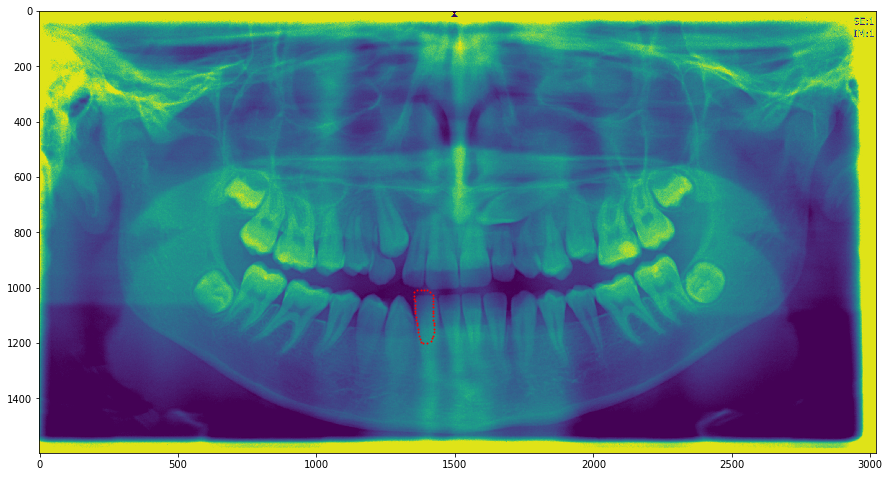

In [169]:
if __name__ == "__main__":

    dir_radiographs = "_Data\Radiographs\*.tif"
    radiographs = ActiveShapeModel.load_files(dir_radiographs)
    radiograph = radiographs[0]
    init = np.load("initial_position.npy")
    
    down_sample = 5
    tooth = init[0,4,:,:]/0.3
    #tooth = tooth/down_sample

    radiograph_pre = pre_processing(radiograph)
    img = resolution_downscale(radiograph_pre,down_sample)

    fig, ax = plt.subplots(figsize=(15, 15))
    plt.imshow(radiograph)
    plt.plot(tooth[:,0], tooth[:,1], 'ro', markersize=1)
    plt.show()

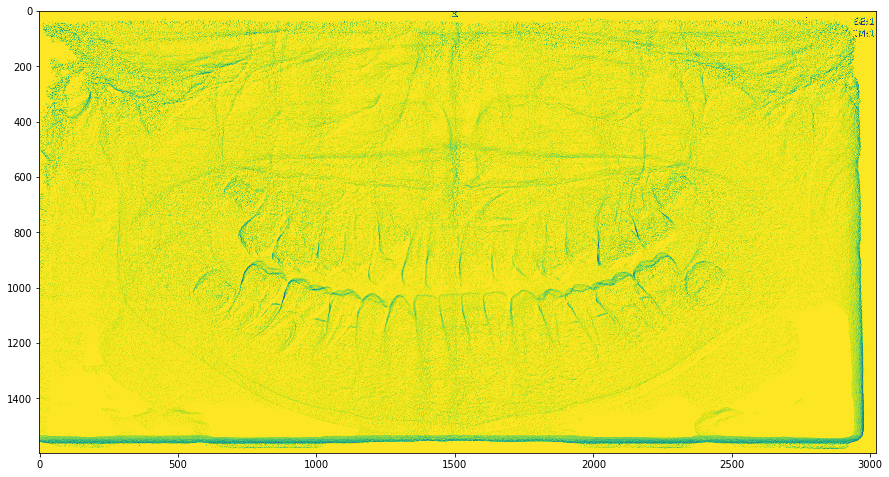

uint8


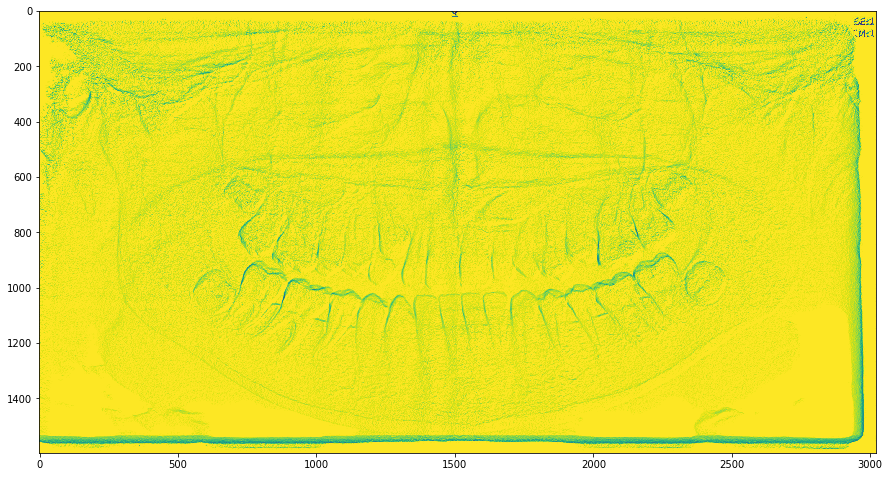

In [196]:
smooth = gaussian_smooth1(radiograph,10)
grad = calc_external_img2(smooth)
grad2 = calc_external_img2(radiograph)
fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(grad2)
plt.show()
print(radiograph.dtype)
np.histogram(grad)
fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(grad)
plt.show()

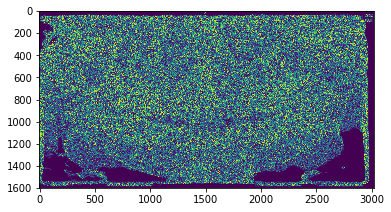

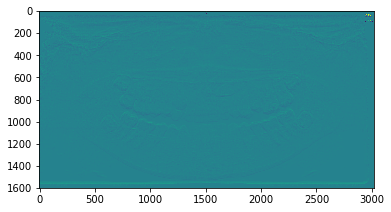

In [185]:
img = radiograph
    
img = rgb2gray(img)

sobelx64f = cv2.Sobel(img,cv2.CV_16S,1,0,ksize=5)
abs_sobel64f = np.absolute(sobelx64f)
sobelx = np.uint8(abs_sobel64f)
plt.imshow(sobelx)
plt.show()

sobely64f = cv2.Sobel(img,cv2.CV_16S,0,1,ksize=5)
abs_sobel64f = np.absolute(sobely64f)
sobely = np.uint8(abs_sobel64f)
plt.imshow(sobely64f)
plt.show()


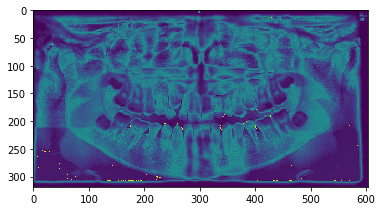

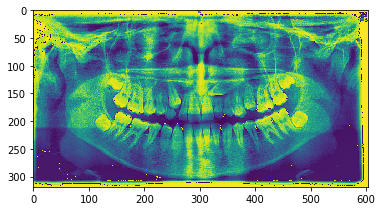

uint8


In [161]:
k1 = np.array([[1,1,1],[1,1,1],[1,1,1]])/9
smoothed = cv2.filter2D(img,-1,k1)

k2 = np.array([[0,0,0],[0,2,0],[0,0,0]])
dubbel = cv2.filter2D(img,-1,k2)
sharp = dubbel - smoothed
sharp2 = 2*img - smoothed

plt.imshow(sharp)
plt.show()
plt.imshow(sharp2)
plt.show()
print(sharp2.dtype)

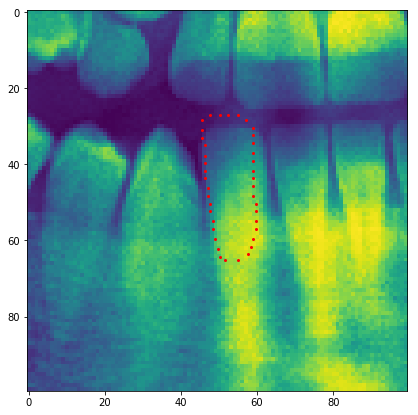

In [103]:
piece = img[175:275, 225:325]
tooth2 = tooth
tooth2[:,0]=tooth[:,0]-225
tooth2[:,1]=tooth[:,1]-175
fig, ax = plt.subplots(figsize=(7, 7))
plt.imshow(piece)
plt.plot(tooth2[:,0], tooth2[:,1], 'ro', markersize=2)
plt.show()

In [141]:
new_tooth = active_contour(tooth2, gausian(piece,1.5), 2, 2, 25)
fig, ax = plt.subplots(figsize=(7, 7))
plt.imshow(piece)
plt.plot(new_tooth[:,0], new_tooth[:,1], 'ro', markersize=2)
plt.show()

NameError: name 'gausian' is not defined

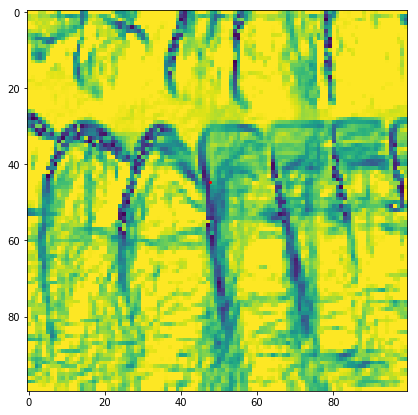

In [137]:
ext3 = calc_external_img2(piece)
fig, ax = plt.subplots(figsize=(7, 7))
plt.imshow(ext3)
plt.plot(tooth2[0,0], new_tooth[0,1], 'ro', markersize=2)
plt.show()

In [87]:
tooth[:,0]=tooth[:,0]-225
tooth[:,1]=tooth[:,1]-175

In [88]:
for p in tooth:
    print(ext3[int(p[0]),int(p[1])])

-234.54637
-149.32515
-50.159744
-0.0
-19.0
-33.970577
-37.0
-0.0
-0.0
-95.38344
-133.22162
-140.89003
-116.0
-90.55385
-33.61547
-6.0
-0.0
-55.0
-68.30813
-111.0
-0.0
-52.0
-2.0
-36.878178
-32.24903
-54.129475
-123.967735
-244.46268
-24.0
-0.0
-31.0
-55.00909
-69.0
-25.96151
-0.0
-35.0
-72.11102
-131.72699
-104.307236
-55.0


In [127]:
mean = calc_mean(tooth)
size = len(tooth)
for i in range(size-1):
    p1 = tooth[i]
    p2 = tooth[i+1]
    print(100*calc_internal_mean(p1,p2, mean))
    

0.5552509464544106
11.38934111907835
10.836321696068287
4.884125675010523
11.389341119080267
10.836321696068287
10.836321696068287
10.836321696068287
17.60233739563152
10.836321696068287
4.884125675010523
10.836321696068287
17.602337395632674
10.836321696068287
17.60233739563383
17.602337395632674
4.884125675010523
70.30381500539035
100.83124943097476
42.54147769484965
4.884125675010523
4.884125675011308
17.602337395634986
10.836321696068287
11.38934111907835
10.836321696068287
4.884125675010523
11.38934111907835
10.836321696068287
10.836321696068287
11.389341119080267
10.836321696068287
11.38934111907835
10.836321696068287
10.836321696068287
24.924201250313256
0.5552509464544106
11.389341119076432
10.836321696068287


In [124]:
mean

2.329185687660753

In [92]:
size = len(tooth)
for i in range(size-1):
    p1 = tooth[i]
    p2 = tooth[i+1]
    print(calc_energy(p1,p2,ext3,0.5))
    

-41.7222222222222
-18.38888888888894
-33.0
-0.5555555555555305
-2.388888888888788
-10.0
-9.5
4.0
-33.94444444444454
-43.69171905517578
-62.166364881727404
-76.65357971191406
-43.218454149034315
-41.27692413330078
-9.252179887559628
-0.9444444444444695
-10.05555555555553
-25.277777777777843
-29.336387210422217
-46.61111111111106
-25.55555555555553
-19.555555555555607
-1.4444444444443185
-12.5
-4.312548213534935
-39.61765670776367
-45.40031645033092
-115.1202273898655
-25.5
4.0
5.611111111111212
-23.504545211791992
-27.38888888888894
-8.980754852294922
4.0
-9.5
-30.27773369683157
-58.75238376193597
-48.15361785888672


In [34]:
ext.dtype

dtype('float64')

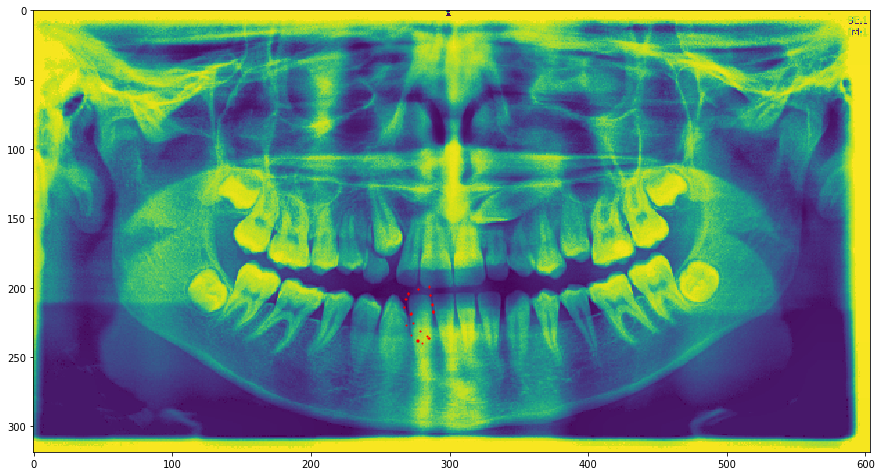

In [173]:
new_tooth = active_contour(tooth, img, 5, 2, 1)

fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(img)
plt.plot(new_tooth[:,0], new_tooth[:,1], 'ro', markersize=1)
plt.show()

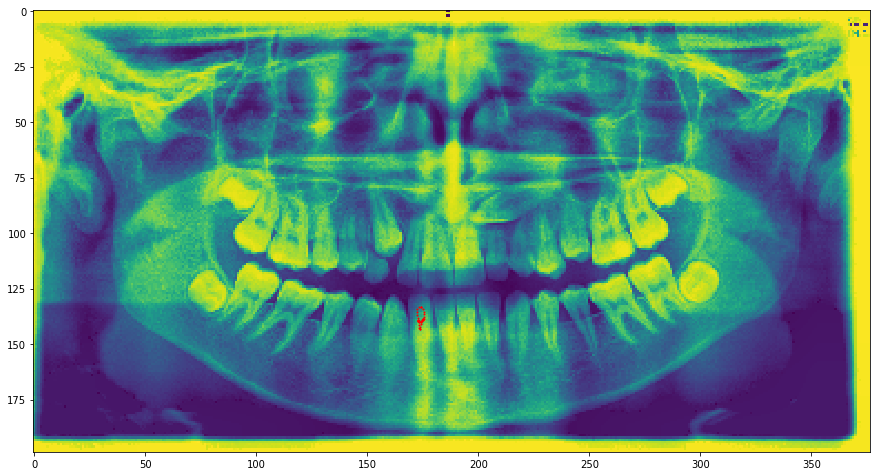

In [143]:
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour

snake = active_contour(radiograph_pre,
                       tooth, alpha=0.015, beta=10, gamma=0.001)

fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(img)
plt.plot(snake[:,0], snake[:,1], 'ro', markersize=1)
plt.show()

In [157]:
a, b, c =[0,0], [2,2], [6,0]
get_normal_angle(a, b, c)

[2. 0.]
[4 2]


1.5707963267948966

In [177]:
def edge_strength_on_normal(a,b,c,length, edge_img):
    
    rad = get_normal_angle(a,b,c)
    points = get_points_on_angle(b, rad, length)
    return edge_strength_at_points(points, edge_img)

def get_normal_angle(a,b,c):
    
    b_proj = project_on(b, a,c)
    b_norm = np.add(b, [2,0])
    return calc_angle(b_proj, b, b_norm)

def project_on(x, a,c):
    n = np.subtract(a, c)
    n = np.divide(n, np.linalg.norm(n, 2))

    return c + n*np.dot(np.subtract(x , c), n)

def calc_angle(a,b,c):
    
    ba = np.subtract(a, b)
    bc = np.subtract(c , b)

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    return np.arccos(cosine_angle)


def get_y_point(x,rad):
    return int(np.around(math.tan(rad) * x))

def get_points_on_angle(point, rad, length):
    
    if  rad > math.pi/4:
        switched = True
        new_rad = math.pi/4 - ( rad - math.pi/4 )
    else:
        switched = False
        new_rad = rad
    
    points = np.empty((2*length+1, 2))
    for i, x in enumerate(range(-length, length+1)):
        
        y = get_y_point(x, new_rad)

        if switched:
            sub_point = [y,x] 
        else:
            sub_point = [x,y]
            
        points[i] = np.subtract(point, sub_point)
        
    return points

def edge_strength_at_points(points ,edge_img):
    
    gradient = np.empty(len(points))
    for i, p in enumerate(points):
        gradient[i] = edge_img[int(p[0]),int(p[1])]
        
    return gradient


def load_tooth():
    init = np.load("initial_position.npy")
    return init[0,4,:,:]/0.3   

def show_with_points(img, points):
    fig, ax = plt.subplots(figsize=(7, 7))
    plt.imshow(img)
    plt.plot(points[:,0], points[:,1], 'ro', markersize=2)
    plt.show()

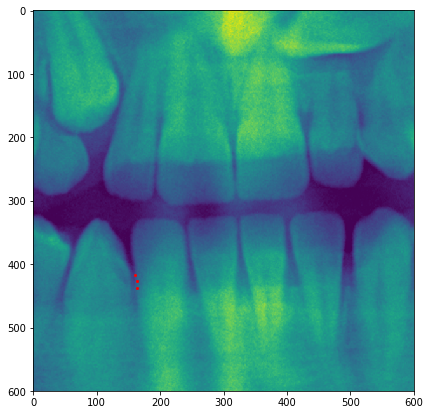

In [165]:
img = prep.load_image()
piece = img[700:1300,1200:1800]

tooth = load_tooth()

tooth2 = tooth
tooth2[:,0]=tooth[:,0]-1200
tooth2[:,1]=tooth[:,1]-700

points = tooth2[10:13]

show_with_points(piece, points)


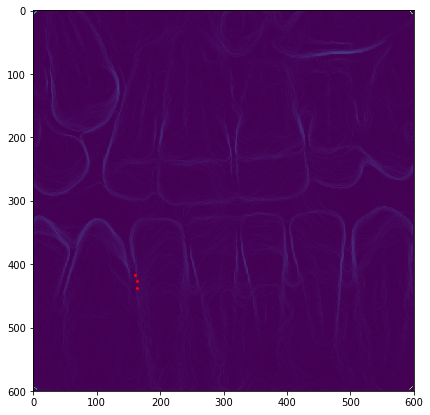

In [183]:
piece = prep.median_filter(piece)
edge_img = prep.edge_detection_low(piece)
show_with_points(edge_img, points)
a,b,c = points
edges = edge_strength_on_normal(a,b,c,20, edge_img)

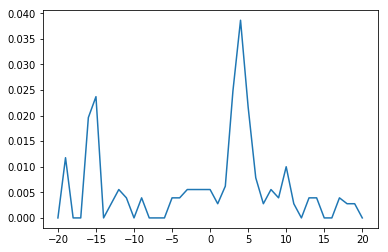

In [182]:
y = np.arange(-20,21)
plt.plot(y, edges)
plt.show()